In [37]:
!pip install pytorch-tabnet 

In [ ]:
!pip uninstall torch

In [36]:
!pip install pytorch

  Using cached pytorch-1.0.2.tar.gz (689 bytes)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for pytorch
Failed to build pytorch
  Running setup.py install for pytorch: started
  Running setup.py install for pytorch: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [6 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\koush\AppData\Local\Temp\pip-install-8xmvxtj7\pytorch_b7a2500e3f734220986a24cbc1ad45b8\setup.py", line 15, in <module>
      raise Exception(message)
  Exception: You tried to install "pytorch". The package named for PyTorch is "torch"
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pytorch
  error: subprocess-exited-with-error
  
  Running setup.py install for pytorch did not run successfully.
  exit code: 1
  
  [6 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\koush\AppData\Local\Te

# 1. Keras Dense Model

In [134]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import seaborn as sns
import itertools
import warnings as ws
ws.filterwarnings("ignore")

In [135]:
# Load the dataset
path = "C:/Users/koush/Downloads/Neural project/S1_File.csv"
df = pd.read_csv(path)

In [136]:
df.head()

,Age at diagnosis,Gender,Months after diagnosis insulin started,Latest BMI,HbA1c,Total Cholesterol,GAD,IA2,Waist,BP Systolic,BP Diastolic,Insulin started more than 6 months after diagnosis?,Family History
0,53,Male,248,23.92,8.5,3.8,< 5.0,< 10.0,85.0,128,74,Yes,No
1,41,Male,15,26.29,10.2,5.7,< 5.0,< 15.0,111.0,133,79,Yes,Yes
2,34,Male,Not on insulin,24.09,6.8,5.0,< 10.0,< 10.0,85.0,152,76,No,No
3,55,Female,Not on insulin,24.77,8.1,4.5,< 5.0,< 10.0,90.0,106,67,No,No
4,34,Female,156,35.13,10.4,5.8,5.01,< 10.0,119.0,146,76,Yes,Yes


**Step 2: Data Preprocessing**

In [137]:
# Encoding categorical variables
le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])

In [138]:
le_insulin_started = LabelEncoder()
df['Insulin started more than 6 months after diagnosis?'] = le_insulin_started.fit_transform(
    df['Insulin started more than 6 months after diagnosis?'])

le_family_history = LabelEncoder()
df['Family History'] = le_family_history.fit_transform(df['Family History'])

In [139]:
# Replace 'Not on insulin' with a large number to indicate no insulin usage
df['Months after diagnosis insulin started'] = df['Months after diagnosis insulin started'].replace('Not on insulin', 999)
df['Months after diagnosis insulin started'] = df['Months after diagnosis insulin started'].astype(int)

In [140]:
def convert_to_numeric(x):
    try:
        return float(x)
    except:
        return float(x.strip('< '))

In [141]:
# Convert '< 5.0' like strings to float
df['GAD'] = df['GAD'].apply(convert_to_numeric)
df['IA2'] = df['IA2'].apply(convert_to_numeric)

In [142]:
# Normalize numerical variables
numerical_cols = ['Age at diagnosis', 'Months after diagnosis insulin started',
                  'Latest BMI', 'HbA1c', 'Total Cholesterol', 'GAD', 'IA2', 'Waist']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [143]:
# Create target variable for hypertension classification
def classify_bp(row):
    sbp, dbp = row['BP Systolic'], row['BP Diastolic']
    if sbp < 120 and dbp < 80:
        return 0  # Normal
    elif 120 <= sbp < 130 and dbp < 80:
        return 1  # Elevated
    elif (130 <= sbp < 140) or (80 <= dbp < 90):
        return 2  # Hypertension Stage 1
    elif sbp >= 140 or dbp >= 90:
        return 3  # Hypertension Stage 2
    elif sbp > 180 or dbp > 120:
        return 4  # Hypertensive Crisis
    else:
        return -1  # Undefined

In [144]:
df['Hypertension Stage'] = df.apply(classify_bp, axis=1)

In [145]:
# Drop BP columns as they are now encapsulated in the target variable
df.drop(['BP Systolic', 'BP Diastolic'], axis=1, inplace=True)

In [146]:
# Splitting the dataset into training and testing sets
X = df.drop('Hypertension Stage', axis=1)
y = df['Hypertension Stage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [147]:
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

**Step 3: Building Model**

In [148]:
# Build the Keras model

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

In [149]:
# Compile the model
optimizer = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [150]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [151]:
# Train the model with validation split
hist = model.fit(X_train, y_train_encoded, epochs=50, batch_size=128,
          validation_split=0.2)
#callbacks=[early_stopping] after the validation split

Epoch 1/50
83/83 [==============================] - 1s 6ms/step - loss: 1.4160 - accuracy: 0.3294 - val_loss: 1.3386 - val_accuracy: 0.3829
Epoch 2/50
83/83 [==============================] - 0s 3ms/step - loss: 1.3359 - accuracy: 0.3607 - val_loss: 1.3205 - val_accuracy: 0.3878
Epoch 3/50
83/83 [==============================] - 0s 3ms/step - loss: 1.3290 - accuracy: 0.3607 - val_loss: 1.3148 - val_accuracy: 0.3780
Epoch 4/50
83/83 [==============================] - 0s 3ms/step - loss: 1.3224 - accuracy: 0.3667 - val_loss: 1.3107 - val_accuracy: 0.3814
Epoch 5/50
83/83 [==============================] - 0s 3ms/step - loss: 1.3243 - accuracy: 0.3679 - val_loss: 1.3093 - val_accuracy: 0.3833
Epoch 6/50
83/83 [==============================] - 0s 3ms/step - loss: 1.3211 - accuracy: 0.3683 - val_loss: 1.3038 - val_accuracy: 0.3840
Epoch 7/50
83/83 [==============================] - 0s 3ms/step - loss: 1.3200 - accuracy: 0.3710 - val_loss: 1.3087 - val_accuracy: 0.3870
Epoch 8/50
83/83 [==

In [152]:
# Predictions
y_train_pred = model.predict(X_train).argmax(axis=1)
y_test_pred = model.predict(X_test).argmax(axis=1)

104/104 [==============================] - 0s 943us/step


In [153]:
# Evaluation
metrics_keras = {
    'Training': {
        'Accuracy': accuracy_score(y_train, y_train_pred),
        'Precision': precision_score(y_train, y_train_pred, average='macro'),
        'Recall': recall_score(y_train, y_train_pred, average='macro'),
        'F1 Score': f1_score(y_train, y_train_pred, average='macro')
    },
    'Testing': {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred, average='macro'),
        'Recall': recall_score(y_test, y_test_pred, average='macro'),
        'F1 Score': f1_score(y_test, y_test_pred, average='macro')
    }
}

In [154]:
metrics_keras

{'Training': {'Accuracy': 0.38305722891566263,
  'Precision': 0.4339238959333085,
  'Recall': 0.300420828590766,
  'F1 Score': 0.23480888420107712},
 'Testing': {'Accuracy': 0.3715748268593797,
  'Precision': 0.35272317039209333,
  'Recall': 0.2949100609901473,
  'F1 Score': 0.2303781066271206}}

In [155]:
# Function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [156]:
# Function to plot ROC Curve
def plot_roc_curve(y_test, y_score, n_classes):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()

In [157]:
# Function to plot Precision-Recall Curve
def plot_precision_recall_curve(y_test, y_score, n_classes):
    # For each class
    precision = dict()
    recall = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])

    # Plot all Precision-Recall curves
    plt.figure()
    for i in range(n_classes):
        plt.plot(recall[i], precision[i], label='Precision-Recall curve of class {0}'.format(i))

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve to multi-class')
    plt.legend(loc="upper right")
    plt.show()

In [158]:
# Number of classes
n_classes = y_train_encoded.shape[1]

In [159]:
n_classes

4

In [160]:
# Compute confusion matrix
cm_keras = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

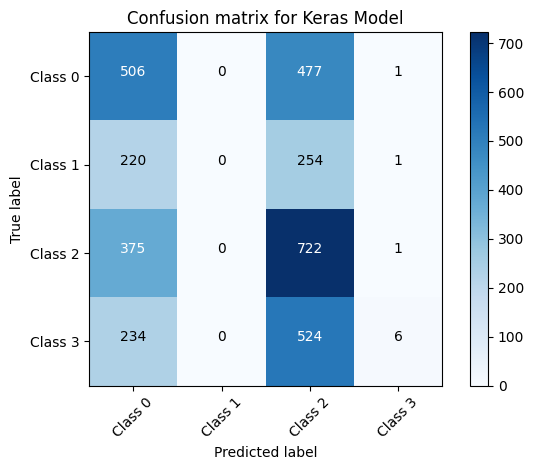

In [161]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cm_keras, classes=[f'Class {i}' for i in range(n_classes)], title='Confusion matrix for Keras Model')

104/104 [==============================] - 0s 944us/step


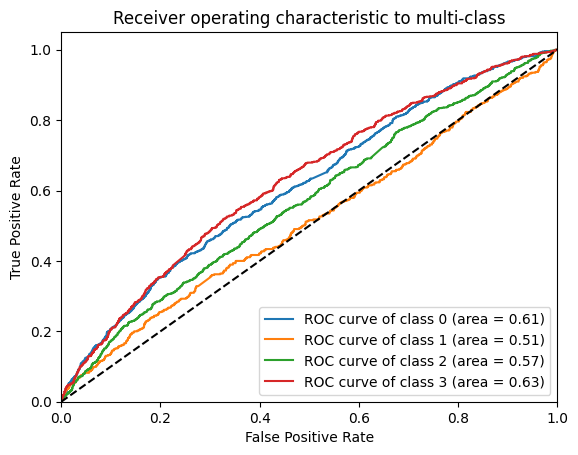

In [162]:
# Plot ROC Curve
y_score_keras = model.predict(X_test)
plot_roc_curve(y_test_encoded, y_score_keras, n_classes)

In [30]:
#from sklearn.metrics import plot_precision_recall_curve

ImportError: cannot import name 'plot_precision_recall_curve' from 'sklearn.metrics' (C:\Users\koush\anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

In [ ]:
#!pip install scikit-learn

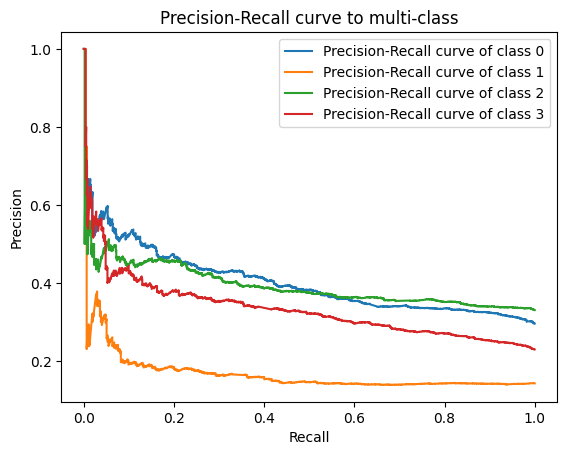

In [163]:
# Plot Precision-Recall Curve
plot_precision_recall_curve(y_test_encoded, y_score_keras, n_classes)

# TabNet Model

In [33]:
from pytorch_tabnet.tab_model import TabNetClassifier

In [164]:
# Convert data to numpy arrays for TabNet
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()

In [165]:
# Define the TabNet model
tabnet_model = TabNetClassifier()

In [166]:
# Train the model
tabnet_model.fit(
  X_train_np, y_train_np,
  max_epochs=30,
  batch_size=32
)

epoch 0  | loss: 1.36185 |  0:00:04s
epoch 1  | loss: 1.33859 |  0:00:09s
epoch 2  | loss: 1.33541 |  0:00:14s
epoch 3  | loss: 1.33186 |  0:00:18s
epoch 4  | loss: 1.3314  |  0:00:23s
epoch 5  | loss: 1.33072 |  0:00:27s
epoch 6  | loss: 1.32868 |  0:00:32s
epoch 7  | loss: 1.3276  |  0:00:36s
epoch 8  | loss: 1.32815 |  0:00:41s
epoch 9  | loss: 1.32623 |  0:00:45s
epoch 10 | loss: 1.32546 |  0:00:50s
epoch 11 | loss: 1.32598 |  0:00:54s
epoch 12 | loss: 1.3247  |  0:00:59s
epoch 13 | loss: 1.32425 |  0:01:04s
epoch 14 | loss: 1.32441 |  0:01:08s
epoch 15 | loss: 1.32268 |  0:01:13s
epoch 16 | loss: 1.32168 |  0:01:17s
epoch 17 | loss: 1.32209 |  0:01:22s
epoch 18 | loss: 1.32087 |  0:01:26s
epoch 19 | loss: 1.31868 |  0:01:31s
epoch 20 | loss: 1.32001 |  0:01:35s
epoch 21 | loss: 1.31936 |  0:01:40s
epoch 22 | loss: 1.32126 |  0:01:44s
epoch 23 | loss: 1.32091 |  0:01:49s
epoch 24 | loss: 1.32169 |  0:01:53s
epoch 25 | loss: 1.32014 |  0:01:58s
epoch 26 | loss: 1.32132 |  0:02:02s
e

In [167]:
# Predictions
y_train_pred_tabnet = tabnet_model.predict(X_train_np)
y_test_pred_tabnet = tabnet_model.predict(X_test_np)

In [168]:
# Evaluation for TabNet
metrics_tabnet = {
    'Training': {
        'Accuracy': accuracy_score(y_train, y_train_pred_tabnet),
        'Precision': precision_score(y_train, y_train_pred_tabnet, average='macro'),
        'Recall': recall_score(y_train, y_train_pred_tabnet, average='macro'),
        'F1 Score': f1_score(y_train, y_train_pred_tabnet, average='macro')
    },
    'Testing': {
        'Accuracy': accuracy_score(y_test, y_test_pred_tabnet),
        'Precision': precision_score(y_test, y_test_pred_tabnet, average='macro'),
        'Recall': recall_score(y_test, y_test_pred_tabnet, average='macro'),
        'F1 Score': f1_score(y_test, y_test_pred_tabnet, average='macro')
    }
}

In [169]:
metrics_tabnet

{'Training': {'Accuracy': 0.36995481927710844,
  'Precision': 0.2771169939663587,
  'Recall': 0.289322915053669,
  'F1 Score': 0.2261738984917588},
 'Testing': {'Accuracy': 0.35802469135802467,
  'Precision': 0.3034160336238387,
  'Recall': 0.28309340894241486,
  'F1 Score': 0.21955067357512953}}

In [170]:
# Compute confusion matrix
y_test_pred_tabnet_encoded = to_categorical(y_test_pred_tabnet, num_classes=n_classes)
cm_tabnet = confusion_matrix(y_test, y_test_pred_tabnet)
np.set_printoptions(precision=2)

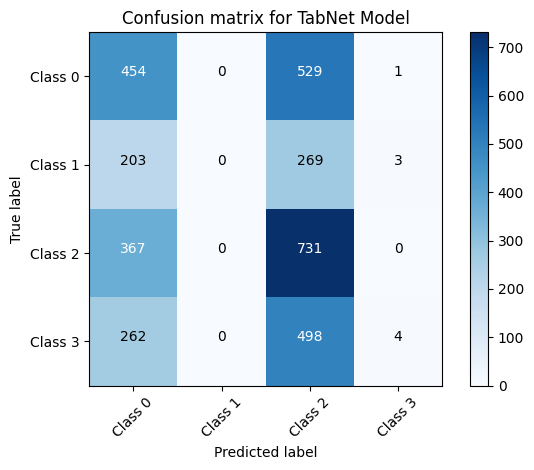

In [171]:
# Plot confusion matrix
plt.figure()
plot_confusion_matrix(cm_tabnet, classes=[f'Class {i}' for i in range(n_classes)], title='Confusion matrix for TabNet Model')


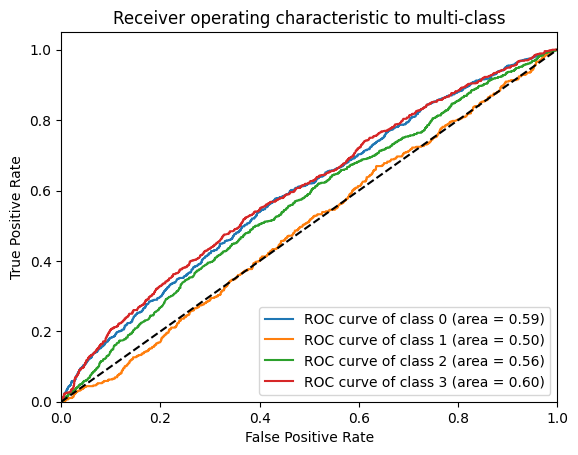

In [172]:
# Plot ROC Curve
y_score_tabnet = tabnet_model.predict_proba(X_test_np)
plot_roc_curve(y_test_encoded, y_score_tabnet, n_classes)

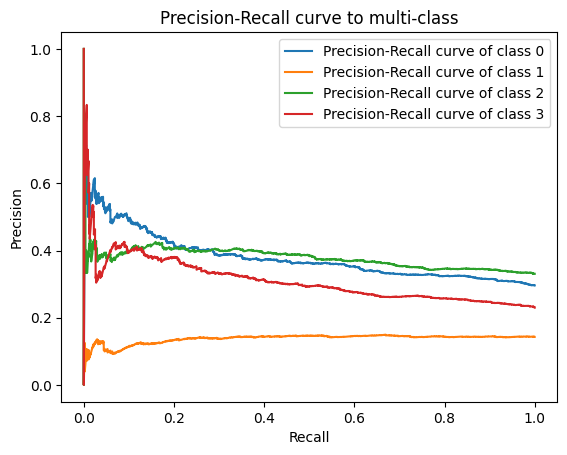

In [173]:
# Plot Precision-Recall Curve
plot_precision_recall_curve(y_test_encoded, y_score_tabnet, n_classes)

In [174]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Embedding, Flatten, concatenate
import keras

def create_tabtransformer_model(num_continuous, cardinalities, num_classes, embed_dim):

    continuous_input = Input(shape=(num_continuous,))

    categorical_inputs = []
    embeddings = []
    for i, cardinality in enumerate(cardinalities):
        cat_input = Input(shape=(1,))
        categorical_inputs.append(cat_input)

        embedding = Embedding(input_dim=cardinality, output_dim=embed_dim, mask_zero=True)(cat_input)
        embedding = Flatten()(embedding)
        embeddings.append(embedding)

    x = concatenate(embeddings, axis=-1)

    # Concatenate continuous and categorical data
    x = concatenate([x, continuous_input], axis=-1)

    x = Dense(84, activation='tanh')(x)
    x = Dropout(0.5)(x)
    x = Dense(84, activation='tanh')(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[continuous_input] + categorical_inputs, outputs=output)

    model.compile(loss=keras.losses.categorical_crossentropy, optimizer='adam', metrics=["accuracy"])

    return model

In [175]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [176]:
num_continuous = 4  
cardinalities = [2, 410, 3, 5, 2, 2] 
embed_dim = 64  

model = create_tabtransformer_model(num_continuous, cardinalities, n_classes, embed_dim)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_38 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_39 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_40 (InputLayer)          [(None, 1)]          0           []                               
                                                                                            

In [177]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_numeric = label_encoder.fit_transform(y_train)
y_val_numeric = label_encoder.transform(y_val)

# Number of classes for the output layer
n_classes = len(label_encoder.classes_)

# Now, y_train_numeric and y_val_numeric contain consistent numeric labels suitable for to_categorical
y_train_onehot = keras.utils.to_categorical(y_train_numeric, n_classes)
y_val_onehot = keras.utils.to_categorical(y_val_numeric, n_classes)
X_train_continuous = X_train.iloc[:, :num_continuous]
X_train_categorical = X_train.iloc[:, num_continuous:]
X_val_continuous = X_val.iloc[:, :num_continuous]
X_val_categorical = X_val.iloc[:, num_continuous:]

train_inputs = [X_train_continuous] + [X_train_categorical.iloc[:, i].values.reshape(-1, 1) for i in range(X_train_categorical.shape[1])]
train_inputs = train_inputs[:len(model.input)]  # Keep only the necessary number of input tensors

val_inputs = [X_val_continuous] + [X_val_categorical.iloc[:, i].values.reshape(-1, 1) for i in range(X_val_categorical.shape[1])]
val_inputs = val_inputs[:len(model.input)]  # Keep only the necessary number of input tensors

hist = model.fit(
    x=[X_train_continuous] + [X_train_categorical.iloc[:, i].values.reshape(-1, 1) for i in range(X_train_categorical.shape[1])],
    y=y_train_onehot,
    epochs=10,
    batch_size=128,
    validation_data=(
        [X_val_continuous] + [X_val_categorical.iloc[:, i].values.reshape(-1, 1) for i in range(X_val_categorical.shape[1])],
        y_val_onehot
    )
)

Epoch 1/10


ValueError: in user code:

    File "C:\Users\koush\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\koush\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\koush\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\koush\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\koush\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\koush\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_5" expects 7 input(s), but it received 8 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 4) dtype=float64>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 1) dtype=float32>, <tf.Tensor 'IteratorGetNext:6' shape=(None, 1) dtype=int32>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 1) dtype=int32>]
